In [51]:
from PIL import Image
import os
import cv2
import numpy as np
from sklearn.metrics import roc_curve, auc

# Directory containing images with unusual extensions
data_dir = 'YaleFaces/'

# Function to read images with unusual extensions and convert to OpenCV format
def read_images(directory):
    images = []
    labels=[]
    for filename in os.listdir(directory):
        if filename.startswith('subject'):  # Adjust the extension as per your dataset
            filepath = os.path.join(directory, filename)
            with Image.open(filepath) as img:
                # Convert image to numpy array
                img=img.resize((100,100))
                np_image = np.array(img)
                images.append(np_image)
                labels.append(filename)
    return images,labels

# Read images from the specified directory
images,labels = read_images(data_dir)

In [7]:
print(labels)

['subject01.centerlight', 'subject01.glasses', 'subject01.happy', 'subject01.leftlight', 'subject01.noglasses', 'subject01.normal', 'subject01.rightlight', 'subject01.sad', 'subject01.sleepy', 'subject01.surprised', 'subject01.wink', 'subject02.centerlight', 'subject02.glasses', 'subject02.happy', 'subject02.leftlight', 'subject02.noglasses', 'subject02.normal', 'subject02.rightlight', 'subject02.sad', 'subject02.sleepy', 'subject02.surprised', 'subject02.wink', 'subject03.centerlight', 'subject03.glasses', 'subject03.happy', 'subject03.leftlight', 'subject03.noglasses', 'subject03.normal', 'subject03.rightlight', 'subject03.sad', 'subject03.sleepy', 'subject03.surprised', 'subject03.wink', 'subject04.centerlight', 'subject04.glasses', 'subject04.happy', 'subject04.leftlight', 'subject04.noglasses', 'subject04.normal', 'subject04.rightlight', 'subject04.sad', 'subject04.sleepy', 'subject04.surprised', 'subject04.wink', 'subject05.centerlight', 'subject05.glasses', 'subject05.happy', 's

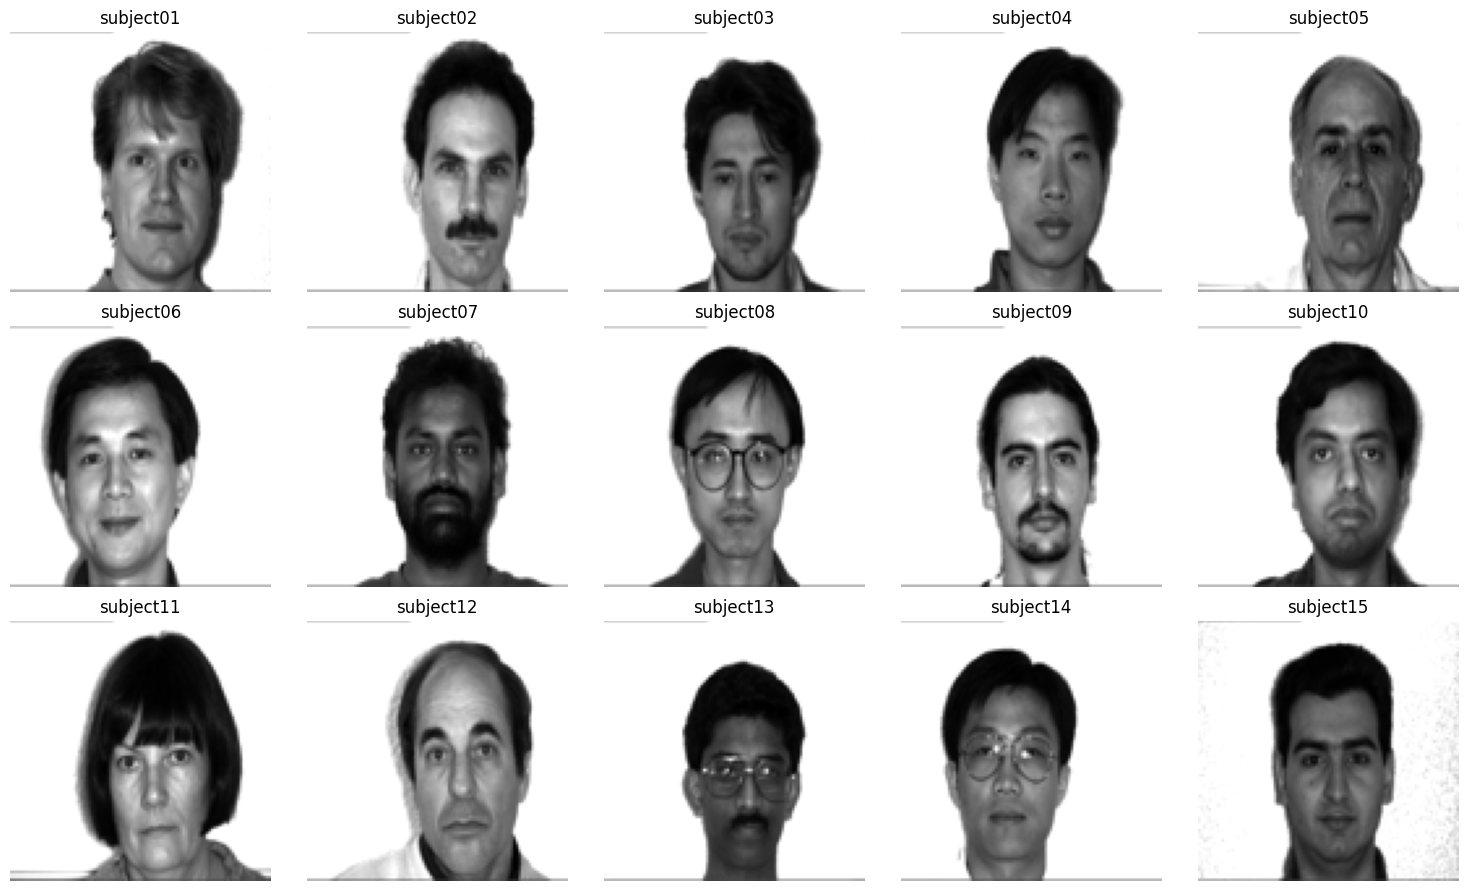

In [12]:
from matplotlib import pyplot as plt

# Display images from each subject in 3 rows
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3 rows, 5 columns

# Dictionary to store the index of the first image for each subject
subject_indices = {}

# Counter for the current row and column
row_index = 0
col_index = 0

# Iterate through the image labels
for filename in labels:
    subject = filename.split('.')[0]  # Extract the subject number from the filename
    
    # If the subject is encountered for the first time, assign a new index and display the image
    if subject not in subject_indices:
        subject_indices[subject] = (row_index, col_index)
        axes[row_index, col_index].imshow(images[labels.index(filename)], cmap='gray')
        axes[row_index, col_index].axis('off')
        axes[row_index, col_index].set_title(subject)
        
        # Update row and column indices
        col_index += 1
        if col_index == 5:  # Move to the next row if the current row is filled
            row_index += 1
            col_index = 0
            
    # Break the loop if we have displayed one image for each subject
    if len(subject_indices) == 15:
        break

plt.tight_layout()
plt.show()



In [58]:
class Eigenfaces:
    def __init__(self):
        self.pca_compunant_dictionary={}
        
    def fit(self,X,y,Eigen_threshold=0.90,min_distance_threshould=10000000):
        flatten_images=[image.flatten() for image in X]
        flatten_images = np.vstack(flatten_images)
        self.mean_image=np.mean(flatten_images, axis=0)
        flatten_images_centroid = flatten_images - self.mean_image
        coverance_matrix=(flatten_images_centroid.T@flatten_images_centroid)/(len(X)-1)
        # print(coverance_matrix.shape)
        print(coverance_matrix[0])
        
        eigenValues, eigenVectors = np.linalg.eig(coverance_matrix)
        print(eigenValues.shape)
        eigenValues_sum=sum(eigenValues)
        print(eigenValues_sum)
        used_eigenValues=[]
        self.used_eigenVectors=[]
        reached_sum=0
        for i,j in zip(eigenValues, eigenVectors):
            if(reached_sum<Eigen_threshold*eigenValues_sum):
                used_eigenValues.append(i)
                self.used_eigenVectors.append(j)
                reached_sum+=i
            else:
                break
        for i,label in enumerate(y):
            self.pca_compunant_dictionary[label]=[]
            for vector in self.used_eigenVectors:
                weight=(flatten_images[i]-self.mean_image)@vector
                self.pca_compunant_dictionary[label].append(weight)
        print(self.pca_compunant_dictionary) 

    def predict(self, X):
        predictions = []
        for x in X:
            x_flat = x.flatten()
            value_weights = []
            for vector in self.used_eigenVectors:
                weight = (x_flat - self.mean_image) @ vector
                value_weights.append(weight)
            label_distance_dic = {}
            for label, weights in self.pca_compunant_dictionary.items():
                distance = np.sqrt(np.sum((np.array(weights) - np.array(value_weights)) ** 2))
                label_distance_dic[label] = distance
            sorted_dict = sorted(label_distance_dic.items(), key=lambda item: item[1])
            predictions.append(sorted_dict[0][0][:10])  # Take the top prediction
        return predictions

    def predict_proba(self, X):
        proba = []
        for x in X:
            x_flat = x.flatten()
            value_weights = []
            for vector in self.used_eigenVectors:
                weight = (x_flat - self.mean_image) @ vector
                value_weights.append(weight)
            label_distance_dic = {}
            for label, weights in self.pca_compunant_dictionary.items():
                distance = np.sqrt(np.sum((np.array(weights) - np.array(value_weights)) ** 2))
                label_distance_dic[label] = distance
            # Compute softmax probabilities based on distances
            distances = np.array([label_distance_dic[label] for label in self.pca_compunant_dictionary.keys()])
            exp_distances = np.exp(-distances)
            softmax = exp_distances / np.sum(exp_distances)
            proba.append({label: p for label, p in zip(self.pca_compunant_dictionary.keys(), softmax)})
        return proba
    
    
    def score(self, X, y):
        predictions = self.predict(X)
        correct = sum(1 for pred, true in zip(predictions, y) if pred[:10] == true[:10])
        return correct / len(y)
    
    def roc_curve(self, X, y):
        y_scores = self.predict_proba(X)
        fpr, tpr, thresholds = roc_curve(y, y_scores, pos_label='positive class label')
        roc_auc = auc(fpr, tpr)
        return fpr, tpr, roc_auc


In [59]:
import joblib

In [60]:
from sklearn.model_selection import train_test_split, cross_validate

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
classi=Eigenfaces()
classi.fit(X_train,y_train)


[387.60282211 363.26092991 341.60687023 ...   6.63058062  11.56419153
  34.74936387]
(10000,)
(44357105.99676162+0j)
{'subject08.sad': [(13.900602765676625+5.179877061936936j), (0.593709961688377+0.26550031608239527j), (0.24804482522276813-0.042143750893250786j), (0.21187149366340263-0.11268193105802071j), (-0.1941474283911755+0.6863193664984113j), (0.23806279975428235-0.22119984573279478j), (-1.5598900942349976-0.6513512774416034j), (3.86726414053498+0.24755183569540584j), (0.9271194382019436-1.2753327025535048j), (1.547303537231305-0.3085766279472477j), (-1.3424535405130658+0.35964970976369526j), (0.9206858564994587-0.07058249073977318j), (-3.8127196503567684+0.21813824348831967j), (4.191942375675554-1.5603733016802634j), (-0.7267193334417995+0.41665428923297454j), (-0.12508050053073083+1.4775958464999368j), (6.147735399982851-0.6820190459000495j), (-3.139372264715532+0.25536098052493517j), (12.950398104459257-0.6395292307607877j), (-7.183480619551215+1.9933651492324653j), (1.3867566

In [61]:
joblib.dump(classi , "model.pkl")

['model.pkl']

In [62]:
model = joblib.load("model.pkl")

In [47]:
# print(classi.predict(X_train[0]))
# print(y_train[0])
count=0
y_pred = []
for x1,y1 in zip(X_test,y_test):
    if(model.predict(x1)[0][0][:10]==y1[:10]):
        y_pred.append(model.predict(x1)[0][0][:10])
        count+=1
    # else:
    #     print(classi.predict(x1)[0][0][:10])
    #     print(y1[:10])
print("test acurrecy : ",count/len(X_test))
count=0
for x1,y1 in zip(X_train,y_train):
    if(model.predict(x1)[0][0][:10]==y1[:10]):
        count+=1
    # else:
    #     print(classi.predict(x1)[0][0][:10])
    #     print(y1[:10])
print("train acurrecy : ",count/len(X_train))

# print(count)
# print(le)

test acurrecy :  0.8484848484848485
train acurrecy :  1.0


In [63]:
model.score(X_test,y_test)

0.8484848484848485

In [64]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def compute_roc_curve( y_true, y_scores):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Compute area under the curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()  

In [66]:
# Obtain predicted probabilities instead of predictions
y_scores = model.predict_proba(X_test)
print(y_scores)
# Use the predicted probabilities to compute ROC curve
compute_roc_curve(y_test, y_scores)


[{'subject08.sad': (-1.3144573597106438e-15-1.3715868885631155e-15j), 'subject01.happy': (-2.5627976947001438e-12+5.233118015372709e-13j), 'subject09.rightlight': (2.1490060771273842e-13-1.5638971334534944e-13j), 'subject05.glasses': (1.3692498408588545e-15-5.408919377118266e-16j), 'subject04.surprised': (-9.769628665967529e-08-2.775028183171263e-07j), 'subject07.leftlight': (-4.01722431818822e-07-2.3590428670880626e-06j), 'subject15.centerlight': (5.626251759248818e-09+4.662341843717119e-09j), 'subject03.noglasses': (-1.8974229899507444e-09+7.426926710114182e-10j), 'subject13.surprised': (-1.909153066624365e-12+7.976607017122789e-13j), 'subject11.sad': (2.886341442903002e-06-1.1720980512726394e-06j), 'subject09.normal': (2.826451571334336e-19-1.6943411990417345e-18j), 'subject13.glasses': (-3.1547631458918426e-13-2.512761241715567e-13j), 'subject04.leftlight': (-1.379997219166268e-05-8.680097150091396e-07j), 'subject08.normal': (5.733523404127897e-14-3.8485947949463453e-13j), 'subject

ValueError: multiclass format is not supported

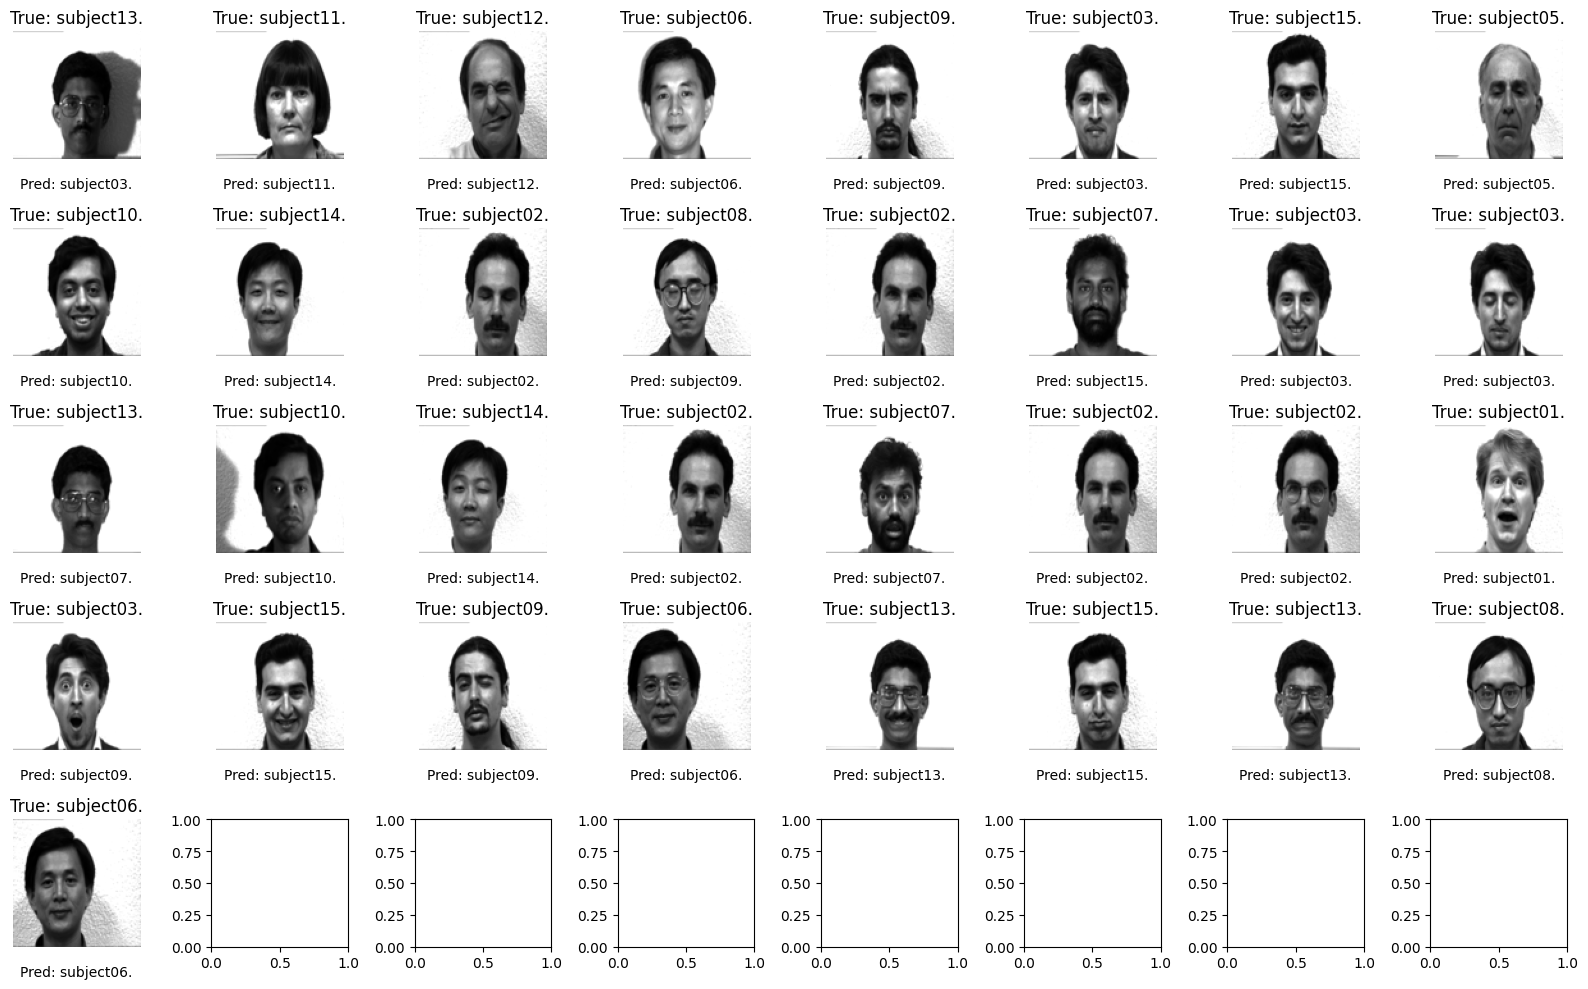

In [19]:
# Testing the Eigenfaces model and displaying results
num_columns = 8
num_rows = (len(X_test) + num_columns - 1) // num_columns  # Calculate number of rows needed
fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 2 * num_rows))

for i, (x, true_label) in enumerate(zip(X_test, y_test)):
    row = i // num_columns
    col = i % num_columns

    # Show the image being tested
    axes[row, col].imshow(x, cmap='gray')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'True: {true_label[:10]}')

    # Predict label for the test image
    predicted_label = classi.predict(x)[0][0][:10]

    # Show the predicted label
    axes[row, col].text(0.5, -0.2, f'Pred: {predicted_label}', fontsize=10, ha='center', va='center', transform=axes[row, col].transAxes)

plt.tight_layout()
plt.show()



# end of code

In [7]:
import numpy as np

# Define the matrix
A = np.array([[2, -1],
              [-1, 3]])

# Step 2: Form the characteristic equation and calculate its determinant
def characteristic_equation(matrix, eigenvalue):
    identity = np.eye(matrix.shape[0])  # Identity matrix
    return np.linalg.det(matrix - eigenvalue * identity)

# Step 3: Solve the characteristic equation to find eigenvalues
def find_eigenvalues(matrix):
    eigenvalues = []
    for eigenvalue_guess in np.linspace(-10, 10, num=1000):  # Guess eigenvalues
        root = np.round(np.roots([1, -eigenvalue_guess]), 8)  # Solve characteristic equation
        for r in root:
            if np.isreal(r):  # Check if the roots are real
                if np.isclose(characteristic_equation(matrix, r), 0,atol=1
                ):  # Check if it's a root
                    eigenvalues.append(np.real(np.round(r, 8)))  # Append the root
    return eigenvalues

# Find eigenvalues
eigenvalues = find_eigenvalues(A)
print("Eigenvalues:", eigenvalues)


Eigenvalues: [1.01101101, 1.03103103, 1.05105105, 1.07107107, 1.09109109, 1.11111111, 1.13113113, 1.15115115, 1.17117117, 1.19119119, 1.21121121, 1.23123123, 1.25125125, 1.27127127, 1.29129129, 1.31131131, 1.33133133, 1.35135135, 1.37137137, 1.39139139, 1.41141141, 1.43143143, 1.45145145, 1.47147147, 1.49149149, 1.51151151, 1.53153153, 1.55155155, 1.57157157, 1.59159159, 1.61161161, 1.63163163, 1.65165165, 1.67167167, 1.69169169, 1.71171171, 1.73173173, 1.75175175, 1.77177177, 1.79179179, 1.81181181, 1.83183183, 1.85185185, 1.87187187, 1.89189189, 1.91191191, 1.93193193, 1.95195195, 1.97197197, 1.99199199, 3.01301301, 3.03303303, 3.05305305, 3.07307307, 3.09309309, 3.11311311, 3.13313313, 3.15315315, 3.17317317, 3.19319319, 3.21321321, 3.23323323, 3.25325325, 3.27327327, 3.29329329, 3.31331331, 3.33333333, 3.35335335, 3.37337337, 3.39339339, 3.41341341, 3.43343343, 3.45345345, 3.47347347, 3.49349349, 3.51351351, 3.53353353, 3.55355355, 3.57357357, 3.59359359, 3.61361361, 3.63363363, 3.

In [9]:
cross_validation = StratifiedKFold(n_splits=5, random_state=5, shuffle=True)
for train_index, test_index in cross_validation.split(X, y):
        c=classifier
        classifier.fit(X.values[train_index], y.values[train_index])

        y_train_pred = classifier.predict(X.values[train_index])
        y_test_pred = classifier.predict(X.values[test_index])

        train_list.append(np.mean(y_train_pred == y.values[train_index]))
        test_list.append(np.mean(y_test_pred == y.values[test_index]))
      train_scores_lists.append(train_list)
      test_scores_lists.append(test_list)


IndentationError: unindent does not match any outer indentation level (<string>, line 11)

In [ ]:
def PCA1(X, n_components):
    """
    Perform Principal Component Analysis (PCA) on the input data matrix.

    Parameters:
    X (numpy.ndarray): Input data matrix of shape (n_samples, n_features).
    n_components (int): Number of principal components to retain.

    Returns:
    numpy.ndarray: Transformed data matrix of shape (n_samples, n_components).
    numpy.ndarray: Principal components matrix of shape (n_components, n_features).
    """

    # 1. Center the data
    mean = np.mean(X, axis=0)
    centered_X = X - mean

    # 2. Compute the covariance matrix
    covariance_matrix = np.cov(centered_X.T)

    # 3. Compute eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # 4. Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # 5. Select the top n_components eigenvectors
    top_eigenvectors = sorted_eigenvectors[:, :n_components]

    # 6. Project the centered data onto the principal components
    transformed_X = np.dot(centered_X, top_eigenvectors)

    return transformed_X, top_eigenvectors